# Model the short term outcomes for stroke patients

In [1]:
# general
import pandas as pd
import numpy as np

from functions import helper

# plot libarys
import seaborn as sns
import matplotlib.pyplot as plt


# Model preparation
#import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
 

# Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

from sklearn.dummy import DummyClassifier

# Model Metrics
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import f1_score, make_scorer # for modelling.py

# for merging the dataframes
import os, glob
import json

# further libarys
#import itertools
from sklearn.tree import export_graphviz
from collections import Counter

%matplotlib inline

In [2]:
df = pd.read_csv('data/IST_corrected_clean.csv',  index_col= [0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18779 entries, 0 to 19434
Columns: 113 entries, HOSPNUM to RDISCH14
dtypes: float64(16), int64(29), object(68)
memory usage: 16.3+ MB


In [4]:
#convert all 'objects' into 'categories'
df = pd.concat([
        df.select_dtypes([], ['object']),
        df.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1).reindex(df.columns, axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18779 entries, 0 to 19434
Columns: 113 entries, HOSPNUM to RDISCH14
dtypes: category(68), float64(16), int64(29)
memory usage: 7.8 MB


In [6]:
# Reset the index
df.index = pd.RangeIndex(len(df.index))

### Target for 14 days after first stroke

Target for the first model is survival (DDEAD == 'Y') within the first 14 days after the (first) stroke.


In [7]:
# drop missing values from 'RATRIAL'
df = df.dropna(subset = ['RATRIAL'])

In [8]:
print(df.DDEAD.value_counts())
# transform feature into 1/0 
df['DDEAD'] = df.DDEAD == 'Y'
print()
print(df.DDEAD.value_counts())

N    15941
Y     1880
Name: DDEAD, dtype: int64

False    15941
True      1880
Name: DDEAD, dtype: int64


In [9]:
# Select features
features = ['SEX', 'AGE', 'RSBP', 'RDEF1', 'RDEF2', 'RDEF3', 'RDEF4', 'RDEF5', 'RDEF6', 'RDEF7', 'RATRIAL']
#features = ['SEX', 'AGE', 'RSBP', 'RDEF1', 'RDEF2', 'RDEF3', 'RDEF4', 'RDEF5', 'RDEF6', 'RDEF7', 
#                'DASP14', 'DLH14', 'DMH14', 'RASP3', 'RHEP24', 'RDELAY']

X = df[features]

# Select target
y = df.DDEAD


In [10]:
object_col = list(X.select_dtypes(include='category').columns)

# Iterate over object columns
for column in object_col:
    columnSeriesObj = X[column]
    print()
    print('Colunm Name: ', column)
    print('Describe: ', columnSeriesObj.describe())
    if columnSeriesObj.nunique() <= 6:
        print('Unique values: ', columnSeriesObj.unique())
        print('Value counts: ', columnSeriesObj.value_counts()) # Check Categories (particularly 'U' = 'Unknown')


Colunm Name:  SEX
Describe:  count     17821
unique        2
top           M
freq       9514
Name: SEX, dtype: object
Unique values:  ['F', 'M']
Categories (2, object): ['F', 'M']
Value counts:  M    9514
F    8307
Name: SEX, dtype: int64

Colunm Name:  RDEF1
Describe:  count     17821
unique        3
top           Y
freq      13018
Name: RDEF1, dtype: object
Unique values:  ['Y', 'N', 'C']
Categories (3, object): ['Y', 'N', 'C']
Value counts:  Y    13018
N     4576
C      227
Name: RDEF1, dtype: int64

Colunm Name:  RDEF2
Describe:  count     17821
unique        3
top           Y
freq      15366
Name: RDEF2, dtype: object
Unique values:  ['Y', 'N', 'C']
Categories (3, object): ['Y', 'N', 'C']
Value counts:  Y    15366
N     2342
C      113
Name: RDEF2, dtype: int64

Colunm Name:  RDEF3
Describe:  count     17821
unique        3
top           Y
freq      13561
Name: RDEF3, dtype: object
Unique values:  ['Y', 'N', 'C']
Categories (3, object): ['Y', 'N', 'C']
Value counts:  Y    13561
N

No instances with 'U'.

In [11]:
print(sorted(Counter(y).items()))

[(False, 15941), (True, 1880)]


In [12]:
print(f'Patients deceased: {round((df.DDEAD.value_counts()[1] / df.shape[0] * 100),1)} %')
print(f'Patients alive: {round((df.DDEAD.value_counts()[0] / df.shape[0] * 100),1)} %')

Patients deceased: 10.5 %
Patients alive: 89.5 %


We have an imbalanced dataset - with a distribution of 90% alive and 10% deceased patients after an ischaemic stroke. Below 

## Splitting into train and test data

In [13]:
# Split the data in test and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
#convert all 'objects' into 'categories'
X_train = pd.concat([
        X_train.select_dtypes([], ['object']),
        X_train.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1).reindex(X_train.columns, axis=1)

In [15]:
#convert all 'objects' into 'categories' 
X_test = pd.concat([
        X_test.select_dtypes([], ['object']),
        X_test.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1).reindex(X_test.columns, axis=1)

## Imbalances

In [16]:
print(f'                     Patients recovered: {round((y_train.value_counts()[1] / y_train.shape[0] * 100),1)} %')
print(f'Patients not recovered, dependent, dead: {round((y_train.value_counts()[0] / y_train.shape[0] * 100),1)} %')

                     Patients recovered: 10.7 %
Patients not recovered, dependent, dead: 89.3 %


The ratio of the groups is about 1:4. We will implement SMOTEENN. The SMOTE-part of this function will oversample the minority group and the ENN-part (Edited Nearest Neighbours) will provide some clean up by undersampling the majority group. These functions will be implemented before each training each model. At each singular point we will feed the transformed data into SMOTEENN. Let's define the function here:

In [17]:
sme = SMOTEENN(random_state= 42)

NameError: name 'SMOTEENN' is not defined

## Preparation of Data Scaling and Category Encoding
Some models need scaling of numerical features and encoding of categorical features. The sklearn preprocessors are instantiated here and used where necessary in the data transformation step of each model.

In [18]:
# encoder for categories
onehot = OneHotEncoder(drop="first")

# scalers for numerical features
mms = MinMaxScaler()
ss = StandardScaler()

# Prepare list of numerical and categorical columns
num_cols = make_column_selector(dtype_include=np.number)
cat_cols = make_column_selector(dtype_include="category")

## Choosing a metric

We need to define a suitable metric for evaluating model performance. We want to be sure that we predict the survival only in case the patient really was alive after 14 days. Hence, we use precision as final model metric.

## Dummy Classifier

In [ ]:
# Define transformer
transformer = ColumnTransformer([
    ("scale", ss, num_cols),
    ("encode", onehot, cat_cols),
])

# Transform
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)

X_train_trans_r, y_train_r = sme.fit_resample(X_train_trans, y_train)

--- MODEL PARAMETERS ----------
{
    "constant": null,
    "random_state": 42,
    "strategy": "stratified"
}
--- CLASSIFICATION REPORT ----------
              precision    recall  f1-score   support

       False       0.50      0.50      0.50       564
        True       0.50      0.50      0.50       564

    accuracy                           0.50      1128
   macro avg       0.50      0.50      0.50      1128
weighted avg       0.50      0.50      0.50      1128

--- CONFUSION MATRIX ----------
[[284 280]
 [283 281]]


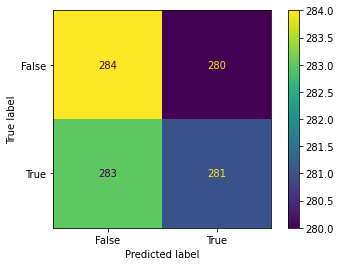

In [19]:
clf_dummy = DummyClassifier(strategy='stratified', random_state=42)

m_dummy = helper.pred_eval_plot_model(X_train_trans_r, X_test_test_r, y_train, y_test, clf_dummy)

### Logistic Regression with Standard Scaler

In [20]:
# Define transformer
transformer = ColumnTransformer([
    ("scale", ss, num_cols),
    ("encode", onehot, cat_cols),
])

# Transform
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)

--- MODEL PARAMETERS ----------
{
    "C": 1.0,
    "class_weight": null,
    "dual": false,
    "fit_intercept": true,
    "intercept_scaling": 1,
    "l1_ratio": null,
    "max_iter": 400,
    "multi_class": "auto",
    "n_jobs": null,
    "penalty": "l2",
    "random_state": 42,
    "solver": "lbfgs",
    "tol": 0.0001,
    "verbose": 0,
    "warm_start": false
}
--- CLASSIFICATION REPORT ----------
              precision    recall  f1-score   support

       False       0.72      0.74      0.73       564
        True       0.73      0.71      0.72       564

    accuracy                           0.72      1128
   macro avg       0.72      0.72      0.72      1128
weighted avg       0.72      0.72      0.72      1128

--- CONFUSION MATRIX ----------
[[415 149]
 [165 399]]


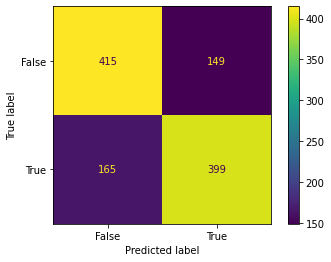

In [21]:
logreg_ss = LogisticRegression(max_iter=400, random_state=42)
m_logreg_ss = modeling.pred_eval_plot_model(X_train_trans, X_test_trans, y_train, y_test, logreg_ss)

+ accuracy .71
+ f: prec 0.71 recall .72
+ t: prec .72 recall .71

In [22]:
# Classification report
y_probs = m_logreg_ss.predict_proba(X_test_trans)[:, 1]

y_pred = y_probs > 0.1
print(f"--- CLASSIFICATION REPORT {'-'*10}")
print(classification_report(y_test,y_pred))
print(f"--- CONFUSION MATRIX {'-'*10}")
print(confusion_matrix(y_test,y_pred))

--- CLASSIFICATION REPORT ----------
              precision    recall  f1-score   support

       False       0.96      0.04      0.08       564
        True       0.51      1.00      0.68       564

    accuracy                           0.52      1128
   macro avg       0.73      0.52      0.38      1128
weighted avg       0.73      0.52      0.38      1128

--- CONFUSION MATRIX ----------
[[ 23 541]
 [  1 563]]


Adjusting the threshold to 0.9, the precision for living patients can be increased to 100%, reducing the F1 Score to 4%.

### Logistic Regression with MinMax Scaling

In [23]:
# Define transformer
transformer = ColumnTransformer([
    ("scale", mms, num_cols),
    ("encode", onehot, cat_cols),
])

# Transform
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)

--- MODEL PARAMETERS ----------
{
    "C": 1.0,
    "class_weight": null,
    "dual": false,
    "fit_intercept": true,
    "intercept_scaling": 1,
    "l1_ratio": null,
    "max_iter": 400,
    "multi_class": "auto",
    "n_jobs": null,
    "penalty": "l2",
    "random_state": null,
    "solver": "lbfgs",
    "tol": 0.0001,
    "verbose": 0,
    "warm_start": false
}
--- CLASSIFICATION REPORT ----------
              precision    recall  f1-score   support

       False       0.71      0.74      0.72       564
        True       0.73      0.70      0.72       564

    accuracy                           0.72      1128
   macro avg       0.72      0.72      0.72      1128
weighted avg       0.72      0.72      0.72      1128

--- CONFUSION MATRIX ----------
[[415 149]
 [167 397]]


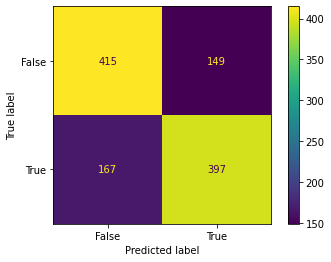

In [24]:
# Calculate the LogisticRegression
logreg = LogisticRegression(max_iter=400)
m_logreg_mm = modeling.pred_eval_plot_model(X_train_trans, X_test_trans, y_train, y_test, logreg)

not as good as standard scaler (minimal!)
+ accuracy .71
+ f: prec 0.71 recall .72
+ t: prec .71 recall .70

In [25]:
# Classification report
y_probs = m_logreg_mm.predict_proba(X_test_trans)[:, 1]

y_pred = y_probs > 0.1
print(f"--- CLASSIFICATION REPORT {'-'*10}")
print(classification_report(y_test,y_pred))
print(f"--- CONFUSION MATRIX {'-'*10}")
print(confusion_matrix(y_test,y_pred))

--- CLASSIFICATION REPORT ----------
              precision    recall  f1-score   support

       False       0.94      0.03      0.05       564
        True       0.51      1.00      0.67       564

    accuracy                           0.51      1128
   macro avg       0.72      0.51      0.36      1128
weighted avg       0.72      0.51      0.36      1128

--- CONFUSION MATRIX ----------
[[ 15 549]
 [  1 563]]


Adjusting the threshold to 0.9, the precision for living patients can be increased to 100%, reducing the F1 Score to 4%.

Overall, there is no difference between using the Standard Scaler and the MinMax Scaler.

### Logistic Regression with Randomized Grid Search

In [26]:
# Define transformer
transformer = ColumnTransformer([
    ("scale", ss, num_cols),
    ("encode", onehot, cat_cols),
])

# Transform
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END C=0.1, l1_ratio=0.25, max_iter=500, penalty=elasticnet, solver=saga; total time=   0.0s
[CV 2/3] END C=0.1, l1_ratio=0.25, max_iter=500, penalty=elasticnet, solver=saga; total time=   0.1s
[CV 3/3] END C=0.1, l1_ratio=0.25, max_iter=500, penalty=elasticnet, solver=saga; total time=   0.0s
[CV 1/3] END C=1000.0, l1_ratio=0.25, max_iter=500, penalty=elasticnet, solver=saga; total time=   0.1s
[CV 2/3] END C=1000.0, l1_ratio=0.25, max_iter=500, penalty=elasticnet, solver=saga; total time=   0.1s
[CV 3/3] END C=1000.0, l1_ratio=0.25, max_iter=500, penalty=elasticnet, solver=saga; total time=   0.1s
[CV 1/3] END C=0.1, l1_ratio=0.0, max_iter=500, penalty=elasticnet, solver=saga; total time=   0.0s
[CV 2/3] END C=0.1, l1_ratio=0.0, max_iter=500, penalty=elasticnet, solver=saga; total time=   0.0s
[CV 3/3] END C=0.1, l1_ratio=0.0, max_iter=500, penalty=elasticnet, solver=saga; total time=   0.0s
[CV 1/3] END C=100.0, l1

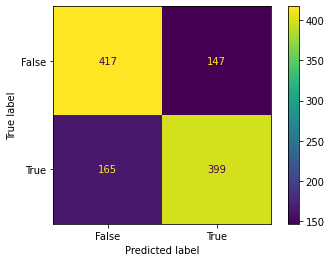

In [27]:
params_grid = {
    "penalty": ["elasticnet"],
    "C": np.logspace(-3, 3, 7),
    "max_iter": [500],
    "l1_ratio": np.arange(0, 1, 0.25),
    "solver": ["saga"],
}
rs_logreg = modeling.run_rand_grid_search(X_train_trans, X_test_trans, y_train, y_test, logreg, params_grid, cv=3, n_iter=20)

+ {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 500, 'l1_ratio': 0.25, 'C': 0.1}
+ 0.7110819743422483
+ f: prec .72, recall .72
+ t: prec. 72, recall .71

The best model with randomized search is achieved with {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 200, 'l1_ratio': 0.75, 'C': 0.1} with a cross-validated F1 Score of 67% for living patients.

The precision of the best model is 61%. Therefore, we could not find a parameter combination that improves precision.

## KNN

### Data Transformation

KNN compares observations based on a similarity measure. Therefore, we need to scale numerical features and use one-hot-encoding for our categorical features. Using one-hot encoding creates a sparse matrix and reduces KNN efficiency. 

In [28]:
X_train_trans = X_train.copy()
X_test_trans = X_test.copy()

# Define transformer
transformer = ColumnTransformer([
    ("scale", ss, num_cols),
    ("encode", onehot, make_column_selector(dtype_include="category")),
])

# Transform
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)

### Simple KNN

We will use the manhattan distance for similarity as our data is sparse.

In [29]:
# Define Classifier
knn = KNeighborsClassifier(p=1, n_jobs=-1)

--- MODEL PARAMETERS ----------
{
    "algorithm": "auto",
    "leaf_size": 30,
    "metric": "minkowski",
    "metric_params": null,
    "n_jobs": -1,
    "n_neighbors": 5,
    "p": 1,
    "weights": "uniform"
}
--- CLASSIFICATION REPORT ----------
              precision    recall  f1-score   support

       False       0.67      0.67      0.67       564
        True       0.67      0.68      0.67       564

    accuracy                           0.67      1128
   macro avg       0.67      0.67      0.67      1128
weighted avg       0.67      0.67      0.67      1128

--- CONFUSION MATRIX ----------
[[377 187]
 [182 382]]


KNeighborsClassifier(n_jobs=-1, p=1)

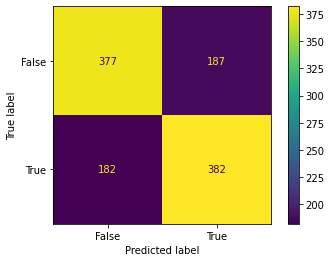

In [30]:
modeling.pred_eval_plot_model(X_train_trans , X_test_trans, y_train, y_test, knn)

+ accuracy: .68
+ f: prec. .67, recall .70
+ t: prec .68, recall .66

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.2s
[CV 2/3] END metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.1s
[CV 3/3] END metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.1s
[CV 1/3] END metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV 2/3] END metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV 3/3] END metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV 1/3] END metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.1s
[CV 2/3] END metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.1s
[CV 3/3] END metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.1s
[CV 1/3] END metric=euclidean, n_neighbors=5, weights=distance; total time=   0.0s
[CV 2/3] END metric=euclidean, n_neighbors=5, weights=distance; total time=   0.1s
[CV 3/3] END metric=euclidean, n

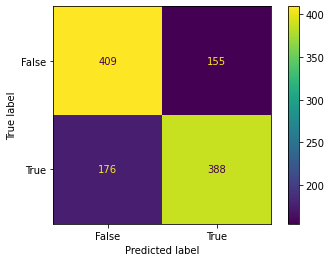

In [31]:
params_grid = {
    'n_neighbors': [3, 5, 11, 19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
gs_knn = modeling.run_grid_search(X_train_trans, X_test_trans, y_train, y_test, knn, params_grid, cv=3)

+ Best model:  {'metric': 'euclidean', 'n_neighbors': 19, 'weights': 'distance'}
+ 0.7019412915851273
+ everything  .71

## Decision Tree

For Decision Trees numerical data doesn't need to be scaled. Categorical data needs to be encoded. As One-Hot-Encoding leads to sparse data and decreases the performance of decision trees, we encode the categories numerically.

In [33]:
# Encode categorical features (with more than two classes)
X_train_trans = X_train.copy()
X_test_trans = X_test.copy()
for cat in ['SEX','RDEF1', 'RDEF2', 'RDEF3', 'RDEF4', 'RDEF5', 'RDEF6', 'RDEF7', 'RATRIAL']:
    X_train_trans[[cat]] = X_train_trans[cat].cat.codes
    X_test_trans[[cat]] = X_test_trans[cat].cat.codes

### Simple Decision Tree

In [34]:
# Define Classifier
dtree = DecisionTreeClassifier(random_state=42)

--- MODEL PARAMETERS ----------
{
    "ccp_alpha": 0.0,
    "class_weight": null,
    "criterion": "gini",
    "max_depth": null,
    "max_features": null,
    "max_leaf_nodes": null,
    "min_impurity_decrease": 0.0,
    "min_impurity_split": null,
    "min_samples_leaf": 1,
    "min_samples_split": 2,
    "min_weight_fraction_leaf": 0.0,
    "random_state": 42,
    "splitter": "best"
}
--- CLASSIFICATION REPORT ----------
              precision    recall  f1-score   support

       False       0.62      0.63      0.63       564
        True       0.63      0.62      0.62       564

    accuracy                           0.62      1128
   macro avg       0.63      0.62      0.62      1128
weighted avg       0.63      0.62      0.62      1128

--- CONFUSION MATRIX ----------
[[357 207]
 [216 348]]


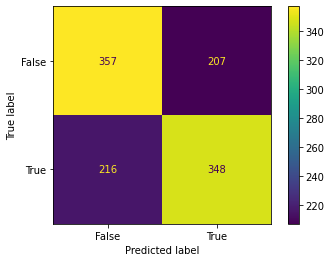

In [35]:
m_dtree = modeling.pred_eval_plot_model(X_train_trans, X_test_trans, y_train, y_test, dtree)

+ accuracy .61
+ f: prec .61, recall .63
+ t: prec .62, recall .59

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ..............max_depth=28, min_samples_leaf=20; total time=   0.0s
[CV 2/5] END ..............max_depth=28, min_samples_leaf=20; total time=   0.0s
[CV 3/5] END ..............max_depth=28, min_samples_leaf=20; total time=   0.0s
[CV 4/5] END ..............max_depth=28, min_samples_leaf=20; total time=   0.0s
[CV 5/5] END ..............max_depth=28, min_samples_leaf=20; total time=   0.0s
[CV 1/5] END ..............max_depth=12, min_samples_leaf=20; total time=   0.0s
[CV 2/5] END ..............max_depth=12, min_samples_leaf=20; total time=   0.0s
[CV 3/5] END ..............max_depth=12, min_samples_leaf=20; total time=   0.0s
[CV 4/5] END ..............max_depth=12, min_samples_leaf=20; total time=   0.0s
[CV 5/5] END ..............max_depth=12, min_samples_leaf=20; total time=   0.0s
[CV 1/5] END ..............max_depth=16, min_samples_leaf=10; total time=   0.0s
[CV 2/5] END ..............max_depth=16, min_sa

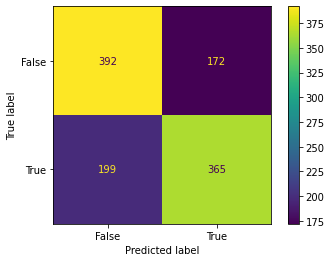

In [36]:
params_grid = {
    "max_depth": np.arange(10, 50, 2),
    "min_samples_leaf": np.arange(10, 30, 2),
}
rs_dtree = modeling.run_rand_grid_search(X_train_trans, X_test_trans, y_train, y_test, dtree, params_grid, n_iter=30)

+ Best model: {'min_samples_leaf': 22, 'max_depth': 22}
+ Best cross-validated Score: 0.7028845390725896

+ accuracy .67
+ f: prec .66, recall .70
+ t: prec .68, recall .65

## Random Forest


In [37]:
# Encode categorical features (with more than two classes)
X_train_trans = X_train.copy()
X_test_trans = X_test.copy()
for cat in ['SEX', 'RDEF1', 'RDEF2', 'RDEF3', 'RDEF4', 'RDEF5', 'RDEF6', 'RDEF7', 'RATRIAL']:
    X_train_trans[[cat]] = X_train_trans[cat].cat.codes
    X_test_trans[[cat]] = X_test_trans[cat].cat.codes

--- MODEL PARAMETERS ----------
{
    "bootstrap": true,
    "ccp_alpha": 0.0,
    "class_weight": null,
    "criterion": "gini",
    "max_depth": null,
    "max_features": "auto",
    "max_leaf_nodes": null,
    "max_samples": null,
    "min_impurity_decrease": 0.0,
    "min_impurity_split": null,
    "min_samples_leaf": 1,
    "min_samples_split": 2,
    "min_weight_fraction_leaf": 0.0,
    "n_estimators": 100,
    "n_jobs": null,
    "oob_score": false,
    "random_state": 42,
    "verbose": 0,
    "warm_start": false
}
--- CLASSIFICATION REPORT ----------
              precision    recall  f1-score   support

       False       0.69      0.67      0.68       564
        True       0.68      0.70      0.69       564

    accuracy                           0.68      1128
   macro avg       0.68      0.68      0.68      1128
weighted avg       0.68      0.68      0.68      1128

--- CONFUSION MATRIX ----------
[[377 187]
 [172 392]]


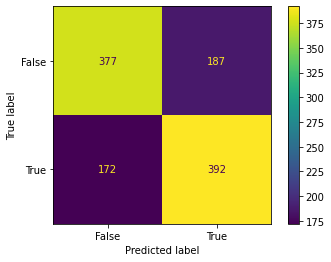

In [38]:
# Define Classifier
rf = RandomForestClassifier(random_state = 42)
m_rf = modeling.pred_eval_plot_model(X_train_trans, X_test_trans, y_train, y_test, rf)

+ accuracy .68
+ f: prec .69, recall .67
+ t: prec .68, recall .70

In [39]:
# Calculate some stats for the random forest:
n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in m_rf.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 1565
Average maximum depth 24


### Grid Search

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END .................................criterion=gini; total time=   0.7s
[CV 2/5] END .................................criterion=gini; total time=   0.6s
[CV 3/5] END .................................criterion=gini; total time=   0.8s
[CV 4/5] END .................................criterion=gini; total time=   0.7s
[CV 5/5] END .................................criterion=gini; total time=   1.1s
[CV 1/5] END ..............................criterion=entropy; total time=   0.5s
[CV 2/5] END ..............................criterion=entropy; total time=   0.5s
[CV 3/5] END ..............................criterion=entropy; total time=   0.6s
[CV 4/5] END ..............................criterion=entropy; total time=   1.0s
[CV 5/5] END ..............................criterion=entropy; total time=   0.6s
--- GRID SEARCH RESULTS ----------
Best model: {'criterion': 'gini'}
Best cross-validated Score: 0.6823666495912727
--- CLASSIFICA

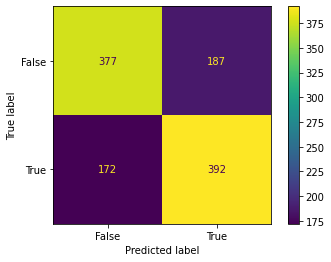

In [42]:
params_grid = {
    "criterion": ["gini", "entropy"],
}
rs_rf = modeling.run_grid_search(X_train_trans, X_test_trans, y_train, y_test, rf,  params_grid)

+ Best model: {'criterion': 'gini'}
+ Best cross-validated Score: 0.6823666495912727

+ accuracy .68
+ f: prec .69, recall .67
+ t: prec .68, recall .70

## ExtraTree

In [44]:
# Encode categorical features (with more than two classes)
X_train_trans = X_train.copy()
X_test_trans = X_test.copy()
for cat in ['SEX', 'RDEF1', 'RDEF2', 'RDEF3', 'RDEF4', 'RDEF5', 'RDEF6', 'RDEF7', 'RATRIAL']:
    X_train_trans[[cat]] = X_train_trans[cat].cat.codes
    X_test_trans[[cat]] = X_test_trans[cat].cat.codes

--- MODEL PARAMETERS ----------
{
    "bootstrap": false,
    "ccp_alpha": 0.0,
    "class_weight": null,
    "criterion": "gini",
    "max_depth": null,
    "max_features": "auto",
    "max_leaf_nodes": null,
    "max_samples": null,
    "min_impurity_decrease": 0.0,
    "min_impurity_split": null,
    "min_samples_leaf": 1,
    "min_samples_split": 2,
    "min_weight_fraction_leaf": 0.0,
    "n_estimators": 100,
    "n_jobs": null,
    "oob_score": false,
    "random_state": 42,
    "verbose": 0,
    "warm_start": false
}
--- CLASSIFICATION REPORT ----------
              precision    recall  f1-score   support

       False       0.66      0.66      0.66       564
        True       0.66      0.67      0.66       564

    accuracy                           0.66      1128
   macro avg       0.66      0.66      0.66      1128
weighted avg       0.66      0.66      0.66      1128

--- CONFUSION MATRIX ----------
[[371 193]
 [188 376]]


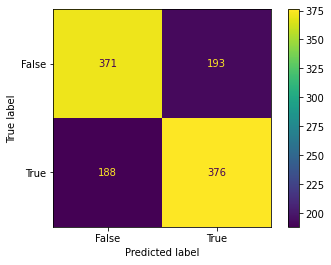

In [45]:
etree = ExtraTreesClassifier(random_state=42)
m_etree = modeling.pred_eval_plot_model(X_train_trans, X_test_trans, y_train, y_test, etree)